### An introduction to the SMILES ARbitrary Target Specification (SMARTS)

Install the necessary Python packages

In [5]:
!pip install rdkit-pypi mols2grid

Load the necessary Python packages

In [6]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit import Chem

IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = 300, 300
rdDepictor.SetPreferCoordGen(True)

### Introduction

The **SM**ILES **AR**bitrary **T**arget **S**pecification (SMARTS) is a language for pattern matching in molecules.  SMARTS provides concise means of matching specific substructures in molecules.  Like SMILES, SMARTS was developed and refined by [Dave Weininger](https://en.wikipedia.org/wiki/David_Weininger) and colleagues at Daylight Chemical Information Systems.  

The canonical reference for SMARTS is the [Daylight Theory Manual](https://www.daylight.com/dayhtml/doc/theory/), I've borrowed liberally from that here. The [Daylight SMARTS Tutorial](https://www.daylight.com/dayhtml_tutorials/languages/smarts/index.html) is another essential reference. 

SMARTS share a lot of the same syntax as SMILES but there are a number of critical differences.  At a simple level, any SMILES is also a valid SMARTS.  However, a query with that SMARTS may not give you the answer you want.  This can best be explained via an example.  

In the RDKit, we can parse a SMARTS and create a molecule with pattern matching abilities using the function **Chem.MolFromSmarts**.  If we look at the depicted structure below, we can see that there are aromatic bonds between the ring atoms.  These bond types are implicit since no bonds were specified.  The bond to the methyl carbon is also not specified, so it is of type **single or aromatic**.

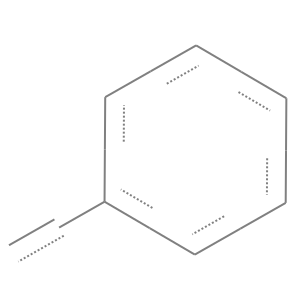

In [7]:
query_mol = Chem.MolFromSmarts("c1ccccc1C")
query_mol

Now, let's create a molecule that we'll match.  As a first example, we'll use ethylbenzene. Since this is a molecule, not a query for searching, we'll use **Chem.MolFromSmiles**. 

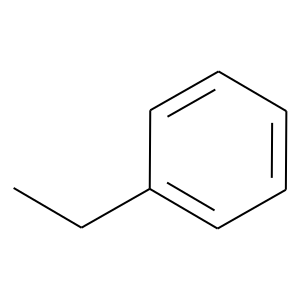

In [8]:
ethyl_benzene = Chem.MolFromSmiles("c1ccccc1CC")
ethyl_benzene

We can now see if our query matches ethyl benzene by using the **HasSubstructMatch** method of the ethyl_benzene molecule object.

In [9]:
ethyl_benzene.HasSubstructMatch(query_mol)

True

The value **True** above indicates that the ethyl_benzene molecule object does indeed contain the substructure specified by query_mol. We can use the function **GetSubstructMatch** to identify the specific atoms matching a pattern. The code below shows that the pattern specified by query_mol matches atoms 0,1,2,3,4,5 and 6.  

In [10]:
ethyl_benzene.GetSubstructMatch(query_mol)

(0, 1, 2, 3, 4, 5, 6)

One interesting side effect of the call to GetSubstructMatch above is that the depiction shows the selected atoms as highlighted. 

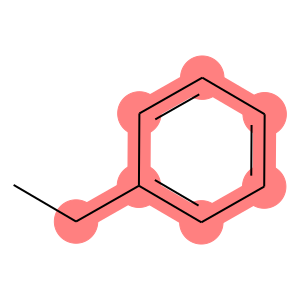

In [11]:
ethyl_benzene

### Properties of Atoms

So far so good, now let's create another molecule and look at how our pattern matches. This time we'll use biphenyl. 

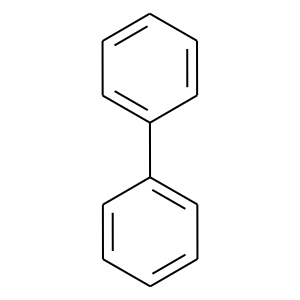

In [12]:
biphenyl = Chem.MolFromSmiles("c1ccccc1c2ccccc2")
biphenyl

In [13]:
biphenyl.HasSubstructMatch(query_mol)

False

Why didn't the query match?  It's because the query SMARTS c1ccccc1**C** specified a phenyl ring connected to an **aliphatic** carbon.  In biphenyl the corresponding carbon atom is aromatic. In SMARTS, "C" only matches aliphatic carbon atoms and "c" only matches aromatic carbon atoms.  If we wish to match any carbon we can use "[#6]" to specify the atom.  

In [14]:
new_query_mol = Chem.MolFromSmarts("c1ccccc1[#6]")
biphenyl.HasSubstructMatch(new_query_mol)

True

A similar approach can be applied with other atom types, we can specify any nitrogen atom as [#7] or any oxygen atom as [#8].   

SMARTS can also be used to query for atoms with a particular charge.  For instance, the SMARTS **[-1]** can be used to identify molecules with a charge of -1.  Note that searching with a SMARTS this way will only identify molecules that were input with a charge of -1.  SMARTS searching does not attempt to determine a molecule's ionization state.  In the example below, we match the SMARTS [-1] against neutral and charged versions of acetic acid. 

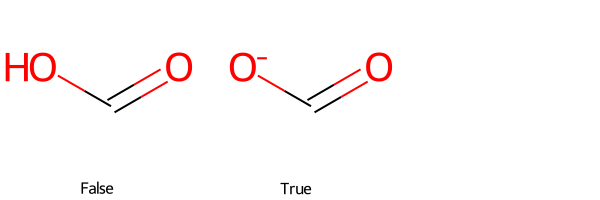

In [15]:
# An list of SMILES with acetic acid and acetate anion
smiles_list = ["C(=O)O","C(=O)[O-]"]
# Convert SMILES to RDKit molecules
mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
# Create a query molecule from SMARTS
anion_query = Chem.MolFromSmarts("[-1]")
# Match the query to the molecules, convert the output to string so that MolsToGrid can display as a legend
match_list = [str(x.HasSubstructMatch(anion_query)) for x in mol_list]
# Draw the structures
Chem.Draw.MolsToGridImage(mol_list,legends=match_list)

### Queries With Atom Lists

In many cases, we want to be able to create a query that will match multiple atom types.  For instance, we may want to create a query that will match both benzene and pyridine.  We can do this by specifying a comma-separated list of atom types in square brackets.  We can specify a query that will match benzene and pyridine with the SMARTS **c1cccc[c,n]1**.

In [16]:
smiles_list = ["c1ccccc1","c1ccccn1"]
mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
query_mol = Chem.MolFromSmarts("c1cccc[c,n]1")
[x.HasSubstructMatch(query_mol) for x in mol_list]

[True, True]

Note that we could also rewrite the query we used above to match aromatic and aliphatic carbon atoms as **c1cccc[c,C]1**.

In [17]:
smiles_list = ["c1ccccc1C","c1ccccc1c2ccccc2" ]
mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
query_mol = Chem.MolFromSmarts("c1cccc[c,C]1")
[x.HasSubstructMatch(query_mol) for x in mol_list]

[True, True]

Atom lists can also include atom specifiers such as [#8].  We can construct a query that matches any carbon or oxygen attached to an aliphatic carbon as **C[#7,#8]**.  

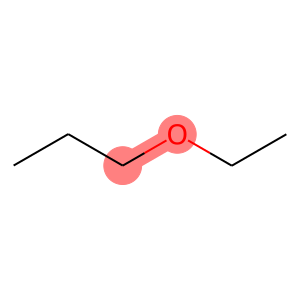

In [18]:
mol = Chem.MolFromSmiles("CCCOCC")
query_mol = Chem.MolFromSmarts("C[#7,#8]")
mol.GetSubstructMatch(query_mol)
mol

### SMARTS Specifying the Number of Attachments to an Atom

There are two ways of writing queries that specify the number of attachments to an atom.  Valence, which is specified with "v" and degree which is specified with "D".  I'm the first to admit that I still confuse these and usually need to write a couple of examples to remember how this works.  In order to do test the two types of queries, let's define a few molecules. 

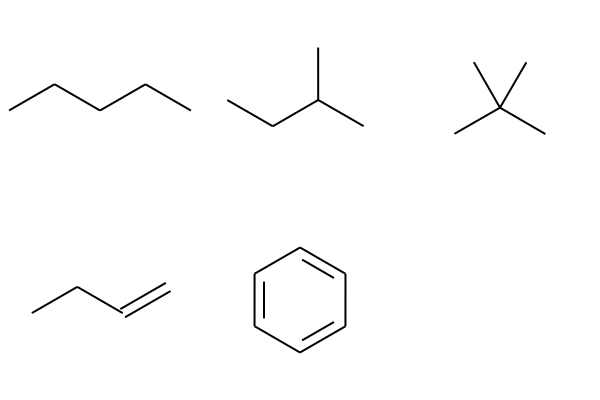

In [19]:
smiles_list = ["CCCCC","CC(C)CC","CC(C)(C)C","C=CCC","c1ccccc1"]
mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
Chem.Draw.MolsToGridImage(mol_list)

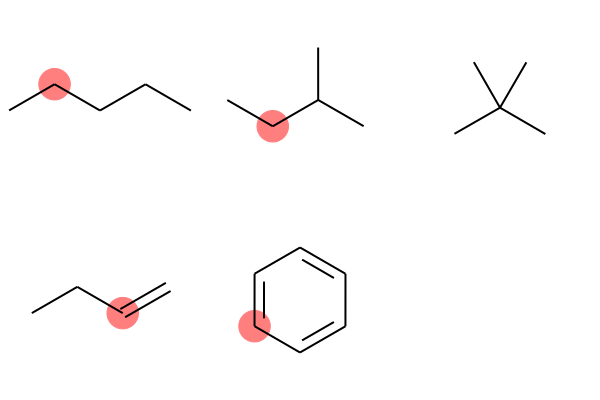

In [20]:
query_smarts = "[D2]"
query_mol = Chem.MolFromSmarts(query_smarts)
match_list = []
for mol in mol_list:
    match_list.append(mol.GetSubstructMatch(query_mol))
Chem.Draw.MolsToGridImage(mol_list,highlightAtomLists=match_list)

In [21]:
mol_list[0].GetSubstructMatches(query_mol)

((1,), (2,), (3,))

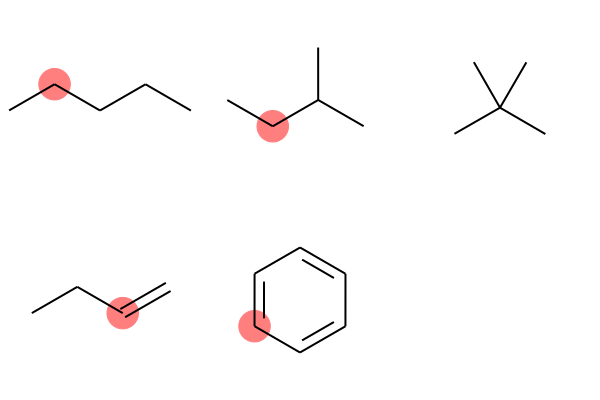

In [22]:
Chem.Draw.MolsToGridImage(mol_list,highlightAtomLists=match_list)

In this section, we'll use the amazing mols2grid component to interactively practice our SMARTS searching skills.  mols2grid provides the ability to create a paginated table of chemical structures.  We can also use this table to select structures and programmatically grab the selected structures.  In addition, mols2grid provides the ability to interactively search the table using SMARTS. A SMARTS search in mols2grid does two things.
- Filters the table so that only molecules matching the SMARTS are shown
- Highlights the atoms matching the SMARTS

In order to search the mols2grid table using SMARTS, we need to do the following: 
- Click on the magnifying glass in the lower right corner
- Select SMARTS

<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/images/smarts_tutorial_using_mols2grid.png" />

In the code block below, we create a grid with the five molecules in mol_list.  Try this out with a few queries.
- aliphatic carbon - C
- aromatic carbon - c
- vinyl group C=C
- trisubstituted carbon [#6D3]
- carbon with three attached bonds [#6X3]

In [23]:
import mols2grid
mols2grid.display(mol_list,substruct_highlight=True)

### Additional Atom Primitives
Use the grid below to try out of some other SMARTS atom primitives.  The table below was taken from [The RDKit Book](https://www.rdkit.org/docs/RDKit_Book.html)
<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/images/smarts_atom_primitives.png" width="800"/>

See if you can find: 
- All the molecules with a six membered ring
- All the molecules with a four membered ring
- All the carboxylic acids
- All the esters
- All the primary amines
- All the sp2 hybridized carbons
- All the atoms contained in 2 rings
- Ureas

In [24]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/data/smarts_test.smi",sep=" ",names=["SMILES","Name"])
mols2grid.display(df,subset=["img","Name"])

### Bond Primitives
Use the grid below to try out of some SMARTS bond primitives.  The table below was taken from [The RDKit Book](https://www.rdkit.org/docs/RDKit_Book.html)
<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/images/smarts_bond_primitives.png" width="500"/>


See if you can find: 
- Sulfur connected by any ring bond to carbon
- A double bond in a ring
- Nitriles
- Any atom triple bonded to any other atom
- A ring carbon bonded to a halogen

In [25]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/data/smarts_test.smi",sep=" ",names=["SMILES","Name"])
mols2grid.display(df,subset=["img","Name"])